In [1]:
include("../init-notebook.jl")

(section-diffusion-boundaries)=
# Boundaries

```{index} method of lines
```

So far we have considered the method of lines for problems with periodic end conditions, which is much like having no boundary at all. How can boundary conditions be incorporated into this technique?

Suppose we are given a nonlinear PDE of the form

:::{math}
  :label: parabolicPDE
  u_t = \phi(t,x,u,u_x,u_{xx}), \quad  a \le x \le b.
:::

Not all such PDEs are parabolic (essentially, including diffusion), but we will assume this to be the case. Suppose also that the solution is subject to the boundary conditions

:::{math}
  :label: parabolicBC
  g_1\left( u(a,t), \frac{\partial u}{\partial x}(a,t) \right) &= 0, \\
  g_2\left( u(b,t), \frac{\partial u}{\partial x}(b,t) \right) &= 0. \\ \\
:::

These include Dirichlet, Neumann, and Robin conditions, which are the linear cases of {eq}`parabolicBC`.

## Boundary removal

```{index} boundary conditions; numerical implementation of
```
As usual, we replace $u(x,t)$ by the semidiscretized $\mathbf{u}(t)$, where $u_i(t)\approx \hat{u}(x_i,t)$ and $i=0,\ldots,m$. We require the endpoints of the interval to be included in the discretization, that is, $x_0=a$ and $x_m=b$. Then we have a division of the semidiscrete unknown $\mathbf{u}(t)$ into interior and boundary nodes:

:::{math}
  :label: mol-divide
  \mathbf{u} =
  \begin{bmatrix}
    u_0 \\ \mathbf{v} \\ u_m
  \end{bmatrix},
:::

where $\mathbf{v}$ are the solution values over the interior of the interval. The guiding principle is to let the interior unknowns $\mathbf{v}$ be governed by a discrete form of the PDE, while the endpoint values are chosen to satisfy the boundary conditions. As a result, we will develop an initial-value problem for the interior unknowns only:

:::{math}
  :label: mol-interior
  \frac{d \mathbf{v}}{d t} = \mathbf{f}(t,\mathbf{v}).
:::

The boundary conditions are used only in the definition of $\mathbf{f}$. As in {numref}`section-bvp-nonlinear`, define 

$$
\mathbf{u}' = \mathbf{D}_x \mathbf{u}.
$$

Then equation {eq}`parabolicBC` takes the form

```{index} rootfinding problem
```

:::{math}
  :label: mol-bcsystem
  g_1( u_0, u'_0 ) &= 0, \\
  g_2( u_m, u'_m ) &= 0.
:::

Given a value of $\mathbf{v}$ for the interior nodes, equation {eq}`mol-bcsystem` may be considered a system of two equations for the unknown boundary values $u_0$ and $u_m$. This system will be a linear one for Dirichlet, Neumann, and Robin conditions. 

(example-boundaries-bs1)=
::::{proof:example}
Recall the Black–Scholes PDE {eq}`bspdefor-t`,
  
$$
u_t = \frac{1}{2} \sigma^2 x^2 u_{xx} + rx u_x - ru,
$$

subject to $u(0)=0$ and $u_x(S_\text{max})=1$. These imply $u_0=0$ and

$$ 
\frac{ 0.5u_{m-2} -2u_{m-1} + 1.5u_{m}}{h} = 1.
$$ 

Hence

$$
\begin{bmatrix}
    1 & 0 \\ 0 & \frac{3}{2}
\end{bmatrix}  \begin{bmatrix}
  u_0 \\ u_m
\end{bmatrix} =
\begin{bmatrix}
  0 \\ h
\end{bmatrix} -
\begin{bmatrix}
  0 & \cdots & 0 & 0 \\
  0 & \cdots & -\frac{1}{2} & 2
\end{bmatrix}
\mathbf{v}.
$$
::::

(example-boundaries-bs2)=
::::{proof:example}
Returning to {numref}`Example {number} <example-boundaries-bs1>`, suppose we use a global Chebyshev differentiation matrix for $\mathbf{D}_x$ in {eq}`mol-bcsystem`. Then $u_0=0$ and

$$ 
D_{m0} u_0 + D_{m1}u_1 + \cdots + D_{mm}u_m = 1.
$$ 

Hence

$$
  \begin{bmatrix}
    1 & 0 \\ D_{m0} & D_{mm}
  \end{bmatrix}  \begin{bmatrix}
  u_0 \\ u_m
\end{bmatrix} =
\begin{bmatrix}
  0 \\ 1
\end{bmatrix} -
\begin{bmatrix}
  0 & \cdots & 0 & 0 \\
  D_{m1} & \cdots & D_{m,m-2}& D_{m,m-1}
\end{bmatrix}
\mathbf{v}.
$$
::::

## Implementation

The steps to evaluate $\mathbf{f}$ in {eq}`mol-interior` now go as follows. 

(algorithm-boundaries-timeder)=
::::{proof:algorithm} Time derivative for parabolic PDE
Given a value of $t$ and $\mathbf{v}$,

1. Use {eq}`mol-bcsystem` to solve for $u_0$ and $u_m$.
2. Assemble the total vector $\mathbf{u}$ from {eq}`mol-divide`.
3. Use the spatial semidiscretization to evaluate $\phi$ at all the nodes.
4. Ignore the boundary nodes to get the value of $\mathbf{f}(t,\mathbf{v})$ in {eq}`mol-interior`.
::::

Our full implementation of the method of lines for {eq}`parabolicPDE`--{eq}`parabolicBC` is given in {numref}`Function {number} <function-parabolic>`. It uses {numref}`Function {number} <function-diffcheb>` to set up a Chebyshev discretization. The nested function `extend` performs steps 1--2 of {numref}`Algorithm {number} <algorithm-boundaries-timeder>` by calling {numref}`Function {number} <function-levenberg>` to solve the potentially nonlinear system {eq}`mol-bcsystem`. Then it sets up and solves an IVP, adding steps 3--4 of {numref}`Algorithm {number} <algorithm-boundaries-timeder>` within the `ode!` function. Finally, it returns the node vector `x` and a function of `t` that applies `extend` to $\mathbf{v}(t)$ to compute $\mathbf{u}(t)$. 

(function-parabolic)=
````{proof:function} parabolic
**Solution of parabolic PDEs by the method of lines**
```{code-block} julia1
:lineno-start: 1
"""
    parabolic(ϕ,xspan,m,g₁,g₂,tspan,init)

Solve a parabolic PDE by the method of lines. The PDE is 
∂u/∂t = `ϕ`(t,x,u,∂u/∂x,∂^2u/∂x^2), `xspan` gives the space 
domain, m gives the degree of a Chebyshev spectral discretization, 
`g₁` and `g₂` are functions of (u,∂u/∂x) at the domain ends that 
should be made zero, `tspan` is the time domain, and `init` is a 
function of x that gives the initial condition. Returns a vector
`x` and a function of t that gives the semidiscrete solution at `x`. 
"""
function parabolic(ϕ,xspan,m,g₁,g₂,tspan,init)
    x,Dₓ,Dₓₓ = diffcheb(m,xspan)
    int = 2:m    # indexes of interior nodes

    function extend(v)
        function objective(ubc)
            u₀,uₘ = ubc
            uₓ = Dₓ*[u₀;v;uₘ]
            return [g₁(u₀,uₓ[1]),g₂(uₘ,uₓ[end])]
        end
        ubc = levenberg(objective,[0,0])[end]
        return [ubc[1];v;ubc[2]]
    end

    function ode!(f,v,p,t)
        u = extend(v)
        uₓ,uₓₓ = Dₓ*u,Dₓₓ*u
        @. f = ϕ(t,x[int],u[int],uₓ[int],uₓₓ[int])
    end

    ivp = ODEProblem(ode!,init.(x[int]),float.(tspan))
    u = solve(ivp)

    return x,t->extend(u(t))
end
```
````

::::{admonition} About the code
:class: dropdown
Line 29 uses the macro `@.` to assign into the vector `f` elementwise. Without it, the function would allocate space for the result of `phi` and then change `f` to point at that vector, and that would defeat the purpose of using the preallocated `f` for speed.
::::

```{index} Dirichlet boundary conditions
```

In many specific problems, `extend` does more work than is truly necessary. Dirichlet boundary conditions, for instance, define $u_0$ and $u_m$ directly, and there is no need to solve a nonlinear system. [Exercise 6](problem-boundaries-dirichlet) asks you to modify the code to take advantage of this case. The price of solving a more general set of problems in {numref}`Function {number} <function-parabolic>` is some speed in such special cases.[^multidisp] 

[^multidisp]: An important advanced feature of Julia is *multiple dispatch*, which allows you to make multiple definitions of a function for different sequences and types of input arguments. Thus, addition to the original {numref}`Function {number} <function-parabolic>`, we could also define a modified version in which `g₁` and `g₂` are of numeric type for the Dirichlet case. The correct version would be chosen (dispatched) depending on how the boundary conditions were supplied by the caller, allowing us speed when possible and generality as a fallback.

(demo-boundaries-heat)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Let's solve the heat equation on $[-1,1]$. First, we define the PDE $u_t=u_{xx}$ and Dirichlet boundary conditions $u(-1,t)=0$, $u(1,t)=2$.

In [2]:
ϕ = (t,x,u,uₓ,uₓₓ) -> uₓₓ
g₁ = (u,uₓ) -> u
g₂ = (u,uₓ) -> u-2;

Our next step is to write a function to define the initial condition. This one satisfies the boundary conditions exactly.

In [3]:
init = x -> 1 + sin(π*x/2) + 3*(1-x^2)*exp(-4x^2);

Now we can use {numref}`Function {number} <function-parabolic>` to solve the problem.

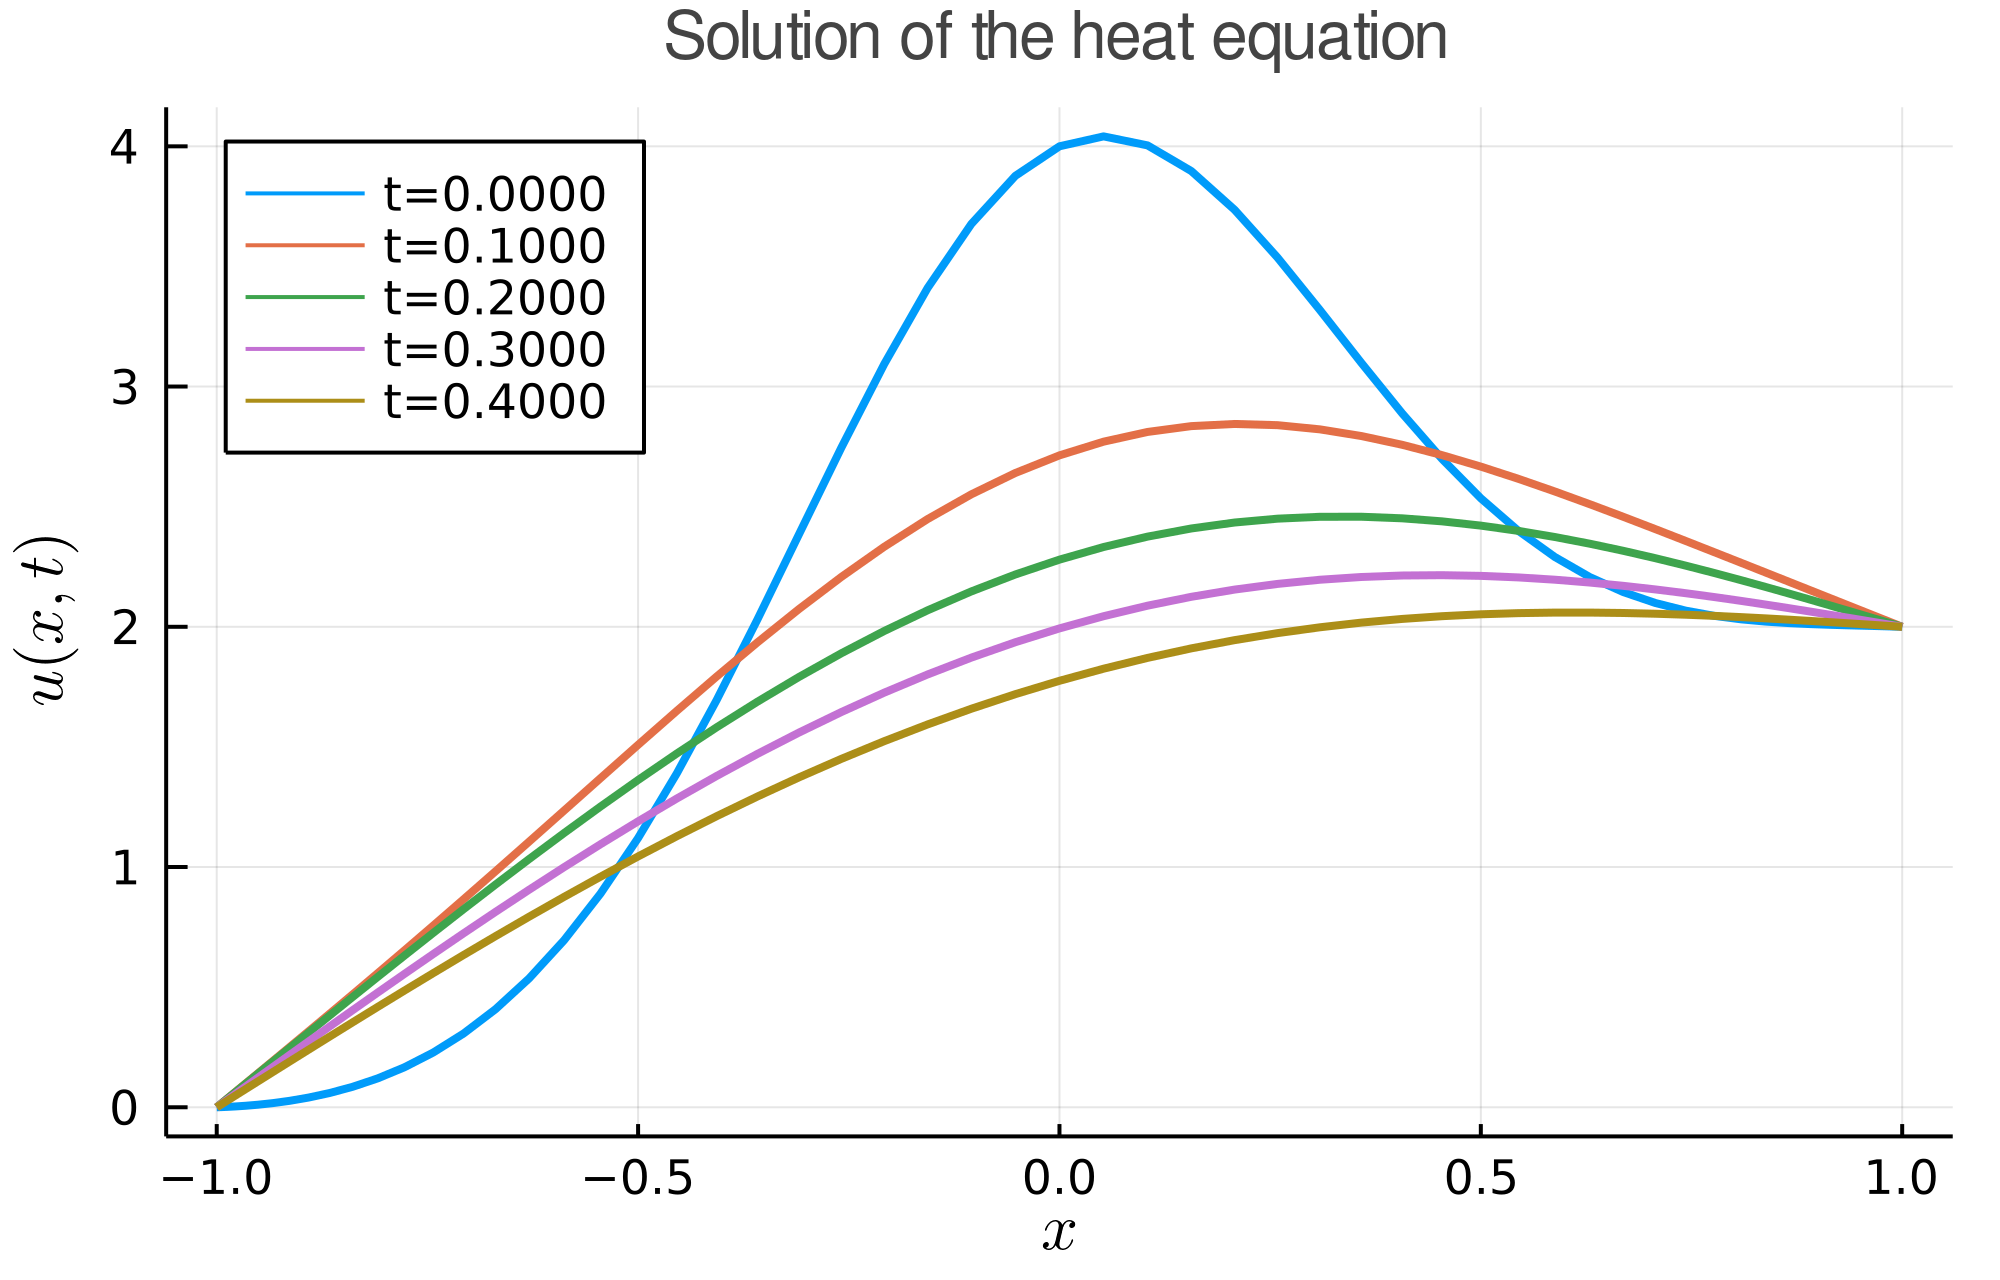

In [4]:
x,u = FNC.parabolic(ϕ,(-1,1),60,g₁,g₂,(0,0.75),init)
plt = plot(xlabel=L"x",ylabel=L"u(x,t)", 
        title="Solution of the heat equation",leg=:topleft)
for t in 0:0.1:0.4
    plot!(x,u(t),label=@sprintf("t=%.4f",t))
end
plt

In [5]:
anim = @animate for t in range(0,0.75,length=201) 
    plot(x,u(t),label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(0,4.2)), 
        title="Heat equation",leg=:topleft,dpi=100)
end
mp4(anim,"boundaries-heat.mp4",fps=30)

Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/diffusion/boundaries-heat.mp4")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

(demo-boundaries-bratu)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve a heat equation with a nonlinear source term,

$$
u_t = u^2 + u_{xx}.
$$

One interpretation of this PDE is an exothermic chemical reaction whose rate increases with temperature. We solve over $x \in [0,1]$ with homogeneous conditions of different kinds.

In [6]:
ϕ = (t,x,u,uₓ,uₓₓ) -> u^2 + uₓₓ
g₁ = (u,uₓ) -> u
g₂ = (u,uₓ) -> uₓ
init = x -> 400x^4*(1-x)^2
x,u = FNC.parabolic(ϕ,(0,1),60,g₁,g₂,(0,0.1),init);

In [7]:
anim = @animate for t in range(0,0.1,length=101) 
    plot(x,u(t),label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(0,10)),dpi=100, 
        title="Heat equation with source",leg=:topleft)
end
mp4(anim,"boundaries-source.mp4",fps=30)

Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/diffusion/boundaries-source.mp4")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Finally, we return to the example of the Black–Scholes equation from {numref}`section-diffusion-blackscholes`. 

(demo-boundaries-bs)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Here is the Black–Scholes PDE, with a homogeneous Dirichlet condition at zero stock price and a nonhomogeneous Neumann condition at the truncated right boundary.

In [8]:
K = 3;  σ = 0.06;  r = 0.08;  Smax = 8;
ϕ = (t,x,u,uₓ,uₓₓ) -> σ^2/2*(x^2*uₓₓ) + r*x*uₓ - r*u
g₁ = (u,uₓ) -> u
g₂ = (u,uₓ) -> uₓ-1;

In [9]:
u₀ = x -> max(0,x-K)
x,u = FNC.parabolic(ϕ,(0,Smax),80,g₁,g₂,(0,15),u₀);

In [10]:
anim = @animate for t in range(0,15,length=151) 
    plot(x,u(t),label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(-0.5,8)),dpi=100, 
        title="Black–Scholes equation",leg=:topleft)
end
mp4(anim,"boundaries-bs.mp4",fps=30)

Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/diffusion/boundaries-bs.mp4")

Recall that $u$ is the value of the call option, and time runs backward from the strike time. The longer the horizon, the more value the option has due to anticipated growth in the stock price.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Exercises

1. ✍ Suppose second-order finite differences with $m=3$ are used to discretize the heat equation on $x \in [0,2]$, with boundary conditions $u_x(0,t)=0$ and $u_x(2,t)=1$. If at some time $t$, $u_1=1$ and $u_2=2$, set up and solve the equations {eq}`mol-bcsystem` for $u_0$ and $u_m$.
   
2. ⌨ Use {numref}`Function {number} <function-parabolic>` to solve the heat equation for $0\le x \le 5$ with initial condition $u(x,0)=x(5-x)$ and subject to the boundary conditions $u(0,t)=0$, $u(5,t)-u_x(5,t)=5$. Plot the solution at $t=1$ and find the value of $u(2.5,1)$. 

3. Consider {numref}`Demo %s <demo-boundaries-bratu>`, combining diffusion with a nonlinear source term.
   
    **(a)** ✍ Suppose we ignore the diffusion. Use separation of variables (or computer algebra) to solve the IVP $u_t=u^2$, $u(0) = A>0$. What happens as $t\to 1/A$ from below? 

    **(b)** ⌨ Try to continue the solution in the demo to $t=1$. What happens? 
    
    **(c)** ⌨ Let the initial condition be $u(x,0) = C x^4(1-x)^2$; the demo uses $C=400$. To the nearest 10, find a critical value $C_0$ such that the solution approaches zero asymptotically if $C < C_0$, but not otherwise.

    ```{index} Allen–Cahn equation
    ```
4. ⌨ The *Allen–Cahn equation* is used as a model for systems that prefer to be in one of two stable states. The governing PDE is

    :::{math}
    u_t = u(1-u^2) + \epsilon u_{xx}.
    :::

    For this problem, assume $\epsilon=10^{-3}$, $-1\le x \le 1$, boundary conditions $u(\pm 1,t) = -1$ and initial condition

    :::{math}
    u(x,0) = -1 + \beta (1-x^2) e^{-20x^2},
    :::

    where $\beta$ is a parameter. Use {numref}`Function {number} <function-parabolic>` with $m=199$.

    **(a)** Solve the problem with $\beta=1.1$ up to time $t=8$, plotting the solution at 6 equally spaced times. (You should see the solution decay down to the constant value $-1$.)

    **(b)** Solve again with $\beta = 1.6$. (This time the part of the bump will grow to just about reach $u=1$, and stay there.)

    ```{index} Fisher equation
    ```
5. ⌨ The *Fisher equation* is $u_t=u_{xx} + u - u^2$. Assume that $0\le x \le 6$, the boundary conditions are $u_x(0,t)=u(6,t)=0$.

    **(a)** For the initial condition $u(x,0) = \frac{1}{2}[1+\cos(\pi x/2)]$, use {numref}`Function {number} <function-parabolic>` with $m=80$ to solve the Fisher equation and plot the solution at times $t=0,0.5,\ldots,3$. What is $u(0,3)$?

    **(b)** Repeat part (a), but increase the final time until it appears that the solution has reached a steady state (i. e., stopped changing in time). Find an accurate value of $u(0,t)$ as $t \to \infty$.

    **(c)** If we set $u_t=0$ in the Fisher equation at steady state, we get a TPBVP in $u(x)$. Use {numref}`Function {number} <function-bvp>` with $m=300$ to solve this BVP, and make sure that the value at $x=0$ matches the result of part (b) to at least four digits.

    (problem-boundaries-dirichlet)=
6. ⌨ Modify {numref}`Function {number} <function-parabolic>` for the special case of Dirichlet boundary conditions, in which {eq}`parabolicBC` becomes simply

    $$
    u(a,t) = \alpha,\; u(b,t)=\beta.
    $$

    Your function should accept numbers $\alpha$ and $\beta$ as input arguments in place of $g_1$ and $g_2$. Test your function on the problem in {numref}`Demo {number} <demo-boundaries-heat>`.

7. ⌨ Modify {numref}`Function {number} <function-parabolic>` for the special case of homogeneous Neumann boundary conditions. There is no longer any need for the input arguments for $g_1$ and $g_2$. Your implementation should solve a $2\times 2$ linear system of equations to find the boundary values within the nested function `extend`. Test your function on the heat equation on $x \in [0,4]$, $t\in [0,1]$ with initial condition $u(x,0)=x^2(4-x)^4.$